# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg


# Imagen para estilo
#!wget https://static1.abc.es/media/historia/2016/10/28/DAVID-GOLIAT-kIdF-U201111563982eOG-620x450@abc.jpg

# Imagen para contenido
#!wget https://static.globalnoticias.pt/jn/image.jpg?brand=JN&type=generate&guid=a59e7930-f7a2-4525-ae90-c4aae2df56c5&w=744&h=495&t=20201125195035

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2021-11-29 20:41:29--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.09s   

2021-11-29 20:41:30 (2.39 MB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2021-11-29 20:41:30--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [2]:
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [3]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")

#base_image_path = Path("/content/image.jpg?brand=JN")
#style_reference_image_path = Path("/content/DAVID-GOLIAT-kIdF-U201111563982eOG-620x450@abc.jpg")
result_prefix = Path("/content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta: 

La total_variation_weight es un escalar que pondera la contribución de cada capa a la loss total. 

La content_weight y la total_variation_weight son los $\alpha$ y $\beta$ de la ecuación:

\begin{align}
\mathcal{L}_{total}(\vec{p},\vec{a},\vec{x}) &= \alpha \mathcal{L}_{content}(\vec{p},\vec{x})+ \beta \mathcal{L}_{style}(\vec{a},\vec{x})
\end{align}

Es decir que ponderan a la loss de contenido y de estilo respectivamente. 

La style_weight es la $w_l$ de la ecuación:

\begin{align}
\mathcal{L}_{style}(\vec{a},\vec{x}) &= \sum_{l=0}^{L}w_lE_l
\end{align}

Este factor se divide por la cantidad de capas activas

In [4]:
total_variation_weight = 0.1
style_weight = 1
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

La función preprocess_image toma una imagen, la convierte a un array que expande, normaliza y luego devuelve como tensor.

np.expand_dims es una función de Numpy que agrega una dimensión al array en el eje cero. Es decir que lo convierte de shape (img_nrows, img_ncols, 3) a (1, img_nrows, img_ncols, 3)

vgg19.preprocess_input convierte las imágenes de entrada de RGB a BGR, y después centra en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar.

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

La función deprocess_image realiza la operación inversa a preprocess_image. Es decir que convierte el tensor en una imágen. Elimina la dimensión que agregó el np.expand_dims, descentra los canales y los convierte a RGB.

In [7]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

La matriz Gram: $G^l \in \Re^{N_lxN_l}$ representa la correlación de características de la imagen de entrada, de manera de recoger el estilo a la salida de cada capa. $G^l_{ij}$ es el producto entre los vectores del mapa de características $i$ y $j$ en la capa $l$: 

\begin{align}
G^l_{ij}= \sum_{k}F^l_{ik}F^l_{jk}
\end{align}

Las dimensiones de x se deben permutar para poder hacer la conversión a 2D de la función batch_flatten.

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

La style_loss es la loss de estilo, y busca mantener el estilo de la imagen de referencia. Se basa en la matriz gram, midiendo la diferencia entre el mapa de características de la imagen generada y la imagen de estilo.

La content_loss es la loss de contenido. Mide la distancia entre el mapa de características de la imagen generada y el de la imagen de contenido. 

La total_variation_loss es la suma ponderada de ambas losses.



In [13]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [14]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [15]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [16]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [17]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

La función fmin_l_bfgs_b del paquete scipy implementa el algoritmo L-BFGS-B para minimizar la función que recibe como parámetro. 

En el paper se utiliza gradient descent. De acuerdo con Le et.al. (2011) los métodos de memoria limitada BFGS son más fáciles de implementar y más rápidos que el más tradicional SGD. 

El paquete scipy ofrece distintos tipos de optimizadores que podrían utilizarse para hacer la minimización. O siguiendo la misma línea del paper citado podría utilizarse Conjugate Gradient, también disponible en scipy.

Por ejemplo, la siguiente imagen se obtuvo utilizando el optimizador truncado de newton (TNC). 

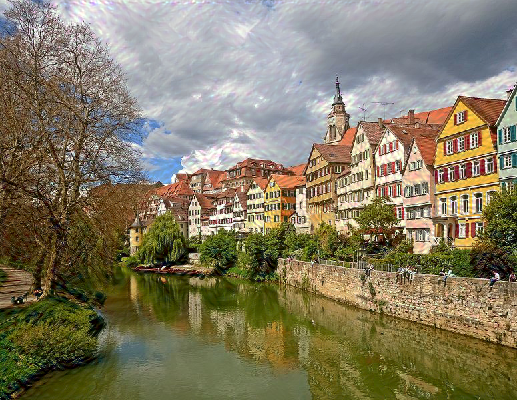

In [18]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [19]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [20]:
#from scipy.optimize import fmin_tnc

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    #x, min_val, info = fmin_tnc(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2648298800.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 24s
Start of iteration 1
Current loss value: 1362451700.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 1032271360.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 16s
Start of iteration 3
Current loss value: 892007800.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 16s
Start of iteration 4
Current loss value: 804342700.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 17s
Start of iteration 5
Current loss value: 751081660.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 16s
Start of iteration 6
Current loss value: 709715600.0
Image saved as /content/output/output_at_iteration_6.png
Iteration 6 completed in 17s
Start of iteration 7
Cur

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: